In [1]:
import VariationalBayes as vb
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

#import copy
from copy import deepcopy
import scipy as sp
#from scipy.sparse.linalg import LinearOperator
from scipy import optimize
from scipy import stats

In [2]:
# Number of data points:
n_num = 1000

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 2

mu_scale = 3
noise_scale = 0.5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

true_z = np.random.multinomial(1, true_pi, n_num)
true_z_ind = np.full(n_num, -1)
for row in np.argwhere(true_z):
    true_z_ind[row[0]] = row[1]

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, mu_scale ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)

true_sigma = np.array([ np.diag(np.full(d_num, noise_scale ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x = np.array([ np.random.multivariate_normal(true_mu[true_z_ind[n]], true_sigma[true_z_ind[n]]) \
               for n in range(n_num) ])


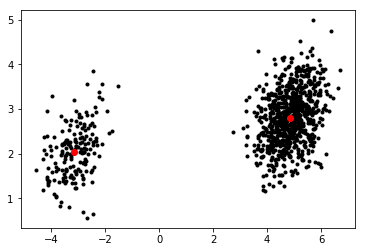

In [3]:
# Never a bad idea to visualize the dataz
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [4]:
global_params = vb.ModelParamsDict('global')
global_params.push_param(
    vb.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    vb.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    vb.SimplexParam(name='pi', shape=(1, k_num)))

local_params = vb.ModelParamsDict('local')
local_params.push_param(
    vb.SimplexParam(name='e_z', shape=(n_num, k_num),
                    val=np.full(true_z.shape, 1. / k_num)))

params = vb.ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

true_init = False
if true_init:
    params['global']['info'].set(true_info)
    params['global']['mu'].set(true_mu)
    params['global']['pi'].set(true_pi)
else:
    params['global']['mu'].set(np.random.random(params['global']['mu'].shape()))
    
init_par_vec = params.get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ 0.65507477  0.9948544 ]
 [ 0.88666462  0.22661001]]
	pi: [[ 0.5  0.5]]


In [5]:
prior_params = vb.ModelParamsDict()
prior_params.push_param(vb.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(vb.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(vb.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(vb.ScalarParam(name='dof', val=d_num + 2.0))

In [6]:
def get_info_logdet_array(info):
    return np.array([ np.linalg.slogdet(info[k, :, :])[1] for k in range(info.shape[0]) ])

# This is the log probability of each observation for each component.
def loglik_obs_by_k(mu, info, pi, x):
    log_lik = \
        -0.5 * np.einsum('ni, kij, nj -> nk', x, info, x) + \
               np.einsum('ni, kij, kj -> nk', x, info, mu) + \
        -0.5 * np.expand_dims(np.einsum('ki, kij, kj -> k', mu, info, mu), axis=0)

    logdet_array = np.expand_dims(get_info_logdet_array(info), axis=0)
    log_pi = np.log(pi)

    log_lik += 0.5 * logdet_array + log_pi
    
    return log_lik


In [7]:
def mu_prior(mu, mu_prior_mean, mu_prior_info):
    k_num = mu.shape[0]
    d_num = len(mu_prior_mean)
    assert mu.shape[1] == d_num
    assert mu_prior_info.shape[0] == d_num
    assert mu_prior_info.shape[1] == d_num
    mu_prior_val = 0.0
    for k in range(k_num):
        mu_centered = mu[k, :] - mu_prior_mean
        mu_prior_val += -0.5 * np.matmul(np.matmul(mu_centered, mu_prior_info), mu_centered)
    return mu_prior_val
    
def pi_prior(pi, alpha):
    return np.sum(alpha * np.log(pi))

def info_prior(info, dof):
    k_num = info.shape[0]
    d_num = info.shape[1]
    assert d_num == info.shape[2]
    assert dof > d_num - 1
    # Not a complete Wishart prior
    # TODO: cache the log determinants.
    info_prior_val = 0.0
    for k in range(k_num):
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        info_prior_val += 0.5 * (dof - d_num - 1) * logdet
    return info_prior_val

# TODO: put this in a library
def multinoulli_entropy(e_z):
    return -1 * np.sum(e_z * np.log(e_z))

def get_sparse_multinoulli_entropy_hessian(e_z_vec):
    k = len(e_z_vec)
    vals = -1. / e_z_vec
    return sp.sparse.csr_matrix((vals, ((range(k)), (range(k)))), (k, k))

weights = np.full((n_num, 1), 1.0)
e_z = params['local']['e_z'].get()
mu_prior(true_mu, mu_prior_mean, mu_prior_info)
pi_prior(true_pi, 2.0)
info_prior(true_info, d_num + 2)
multinoulli_entropy(e_z)

get_multinoulli_entropy_hessian = autograd.hessian(multinoulli_entropy)
e_z0 = e_z[0, :]

print(np.max(np.abs(
    get_multinoulli_entropy_hessian(e_z0) - get_sparse_multinoulli_entropy_hessian(e_z0).toarray())))

0.0


In [8]:

class Model(object):
    def __init__(self, x, params, prior_params):
        self.x = x
        self.params = deepcopy(params)
        self.prior_params = deepcopy(prior_params)
        self.weights = np.full((x.shape[0], 1), 1.0)

        self.get_z_nat_params = autograd.grad(self.loglik_e_z)
        self.get_moment_jacobian = autograd.jacobian(self.get_interesting_moments)
        
    def loglik_obs_by_k(self):
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()        
        return loglik_obs_by_k(mu, info, pi, self.x)

    # This needs to be defined so we can differentiate it for CAVI.
    def loglik_e_z(self, e_z):
        return np.sum(e_z * self.loglik_obs_by_k())

    def loglik(self):
        e_z = self.params['local']['e_z'].get()
        return self.loglik_e_z(e_z)

    def loglik_obs(self):
        log_lik_array = self.loglik_obs_by_k()
        e_z = self.params['local']['e_z'].get()
        return np.sum(log_lik_array * e_z, axis=1)    

    def prior(self):
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()        
        mu_prior_mean = self.prior_params['mu_prior_mean'].get()
        mu_prior_info = self.prior_params['mu_prior_info'].get()
        prior = 0.
        prior += mu_prior(mu, mu_prior_mean, mu_prior_info)
        prior += pi_prior(pi, self.prior_params['alpha'].get())
        prior += info_prior(info, self.prior_params['dof'].get())
        return prior
    
    def optimize_z(self):
        # Take a CAVI step on Z.
        info = self.params['global']['info'].get()
        mu = self.params['global']['mu'].get()
        pi = self.params['global']['pi'].get()
        e_z = self.params['local']['e_z'].get()

        natural_parameters = self.get_z_nat_params(e_z)
        z_logsumexp = np.expand_dims(sp.misc.logsumexp(natural_parameters, 1), axis=1)
        e_z = np.exp(natural_parameters - z_logsumexp)
        self.params['local']['e_z'].set(e_z)
    
    def kl(self, include_local_entropy=True):
        elbo = self.prior() + self.loglik()

        if include_local_entropy:
            e_z = self.params['local']['e_z'].get()
            elbo += multinoulli_entropy(e_z)
        
        return -1 * elbo
    

    #######################
    # Moments for sensitivity
    
    def get_interesting_moments(self, free_params):
        self.params.set_free(free_params)
        return self.params['global']['mu'].get_vector()

    ######################################
    # Compute sparse hessians by hand.

    # Log likelihood by data point.
    
    # The rows are the z vector indices and the columns are the data points.
    def loglik_vector_local_weight_hessian_sparse(self):
        log_lik_array = self.loglik_obs_by_k()

        hess_vals = [] # These will be the entries of dkl / dz dweight^T
        hess_rows = [] # These will be the z indices
        hess_cols = [] # These will be the data indices
        # This is the Hessian of the negative entropy, which enters the KL divergence.
        for row in range(e_z.shape[0]):
            z_row_inds = self.params['local']['e_z'].get_vector_indices(row)
            for col in range(e_z.shape[1]):
                hess_vals.append(log_lik_array[row, col])
                hess_rows.append(z_row_inds[col])
                hess_cols.append(row)

        local_size = self.params['local']['e_z'].vector_size()
        return sp.sparse.csr_matrix((hess_vals, (hess_rows, hess_cols)),
                                     (local_size, self.x.shape[0]))

    # KL
    def kl_vector_local_hessian_sparse(self, global_vec, local_vec):
        self.params['global'].set_vector(global_vec)
        self.params['local'].set_vector(local_vec)
        hess_vals = []
        hess_rows = []
        # This is the Hessian of the negative entropy, which enters the KL divergence.
        e_z = self.params['local']['e_z'].get()
        for row in range(e_z.shape[0]):
            # Note that we are relying on the fact that the local parameters
            # only contain e_z, so the vector index in e_z is the vector index
            # in the local parameters.
            row_inds = self.params['local']['e_z'].get_vector_indices(row)
            for col in range(e_z.shape[1]):
                hess_vals.append(1. / e_z[row, col])
                hess_rows.append(row_inds[col])
        local_size = self.params['local']['e_z'].vector_size()
        return sp.sparse.csr_matrix((hess_vals, (hess_rows, hess_rows)),
                                    (local_size, local_size))

    ######################
    # Everything below here should be boilerplate.
    
    # The SparseObjectives module still needs to support sparse Jacobians. 
    def loglik_free_local_weight_hessian_sparse(self):
        free_par_local = self.params['local'].get_free()
        free_to_vec_jac = self.params['local'].free_to_vector_jac(free_par_local) 
        return free_to_vec_jac .T * \
               self.loglik_vector_local_weight_hessian_sparse()

    def loglik_free_weight_hessian_sparse(self):
        get_loglik_obs_free_global_jac = \
            autograd.jacobian(self.loglik_obs_free_global_local, argnum=0)
        loglik_obs_free_global_jac = \
            get_loglik_obs_free_global_jac(self.params['global'].get_free(),
                                           self.params['local'].get_free()).T
        loglik_obs_free_local_jac = \
            self.loglik_free_local_weight_hessian_sparse()

        return sp.sparse.vstack([ loglik_obs_free_global_jac, loglik_obs_free_local_jac ])
    
    def loglik_obs_free_global_local(self, free_params_global, free_params_local):
        self.params['global'].set_free(free_params_global)
        self.params['local'].set_free(free_params_local)
        return self.loglik_obs()


In [ ]:
model = Model(x, params, prior_params)
model.optimize_z()

kl_obj = SparseObjective(
    model.params, model.kl,
    fun_vector_local_hessian=model.kl_vector_local_hessian_sparse)

kl_obj_dense = Objective(model.params, model.kl)


In [ ]:
free_par = params.get_free()
vec_par = params.get_vector()

kl_obj.fun_free(free_par)
grad = kl_obj.fun_free_grad_sparse(free_par)

hvp_time = time.time()
hvp = kl_obj.fun_free_hvp(free_par, grad)
hvp_time = time.time() - hvp_time

global_free_par = params['global'].get_free()
local_free_par = params['local'].get_free()
grad = kl_obj.fun_free_global_grad(global_free_par, local_free_par)
hess = kl_obj.fun_free_global_hessian(global_free_par, local_free_par)

# You can ignore the autograd warning.
sparse_hess_time = time.time()
sparse_hessian = kl_obj.fun_free_hessian_sparse(free_par)
sparse_hess_time = time.time() - sparse_hess_time

print('Sparse Hessian time: \t\t', sparse_hess_time)
print('Hessian vector product time:\t', hvp_time)

if True:
    dense_hess_time = time.time()
    dense_hessian = kl_obj_dense.fun_free_hessian(free_par)
    dense_hess_time = time.time() - dense_hess_time

    print('Dense Hessian time: \t\t', dense_hess_time)
    print('Difference: ', np.max(np.abs(dense_hessian - sparse_hessian)))



fun_vector_hessian_split: fun_vector_global_hessian:  0.06303071975708008
fun_vector_hessian_split: fun_vector_cross_hessian:  0.05479788780212402
fun_vector_hessian_split: bmat:  0.016865015029907227
fun_vector_hessian_split:  0.1438286304473877
fun_vector_grad_split:  0.006960391998291016
Parameters: free_to_vector_jac:  0.7495548725128174
** calculating hessian:  0.060358285903930664
** appending hessian:  0.006798267364501953
Dict free_to_vector_hess  info :  0.06759023666381836
** calculating hessian:  0.0031616687774658203
** appending hessian:  0.003952503204345703
Dict free_to_vector_hess  mu :  0.007658243179321289
** calculating hessian:  0.0007843971252441406
** appending hessian:  0.0019216537475585938
Dict free_to_vector_hess  pi :  0.003215312957763672
** calculating hessian:  0.07952570915222168
** appending hessian:  0.013369083404541016
Dict free_to_vector_hess  global :  0.09330201148986816


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


** calculating hessian:  0.6455967426300049
** appending hessian:  1.4650421142578125
Dict free_to_vector_hess  e_z :  2.1128995418548584
** calculating hessian:  2.125199794769287
** appending hessian:  1.3184161186218262
Dict free_to_vector_hess  local :  3.444711446762085
Parameters: free_to_vector_hess:  3.549910545349121


In [ ]:
import cProfile
import pstats
cProfile.run('sparse_hessian = kl_obj.fun_free_hessian_sparse(free_par)', 'hessian')

In [ ]:
p = pstats.Stats('hessian')
p.strip_dirs().sort_stats('cumulative').print_stats()

In [ ]:
# Check the weight Jacobians.
get_loglik_obs_free_local_jac = \
    autograd.jacobian(model.loglik_obs_free_global_local, argnum=1)

free_par_global = model.params['global'].get_free()
free_par_local = model.params['local'].get_free()


loglik_obs_free_local_jac = \
    get_loglik_obs_free_local_jac(free_par_global, free_par_local)

loglik_vector_local_weight_hessian_sparse = \
    model.loglik_vector_local_weight_hessian_sparse()

likelihood_by_obs_free_local_jac_sparse = \
    model.loglik_free_local_weight_hessian_sparse()

print(np.max(np.abs(loglik_obs_free_local_jac - likelihood_by_obs_free_local_jac_sparse)))


In [ ]:
# Perform EM.

model.params.set_free(init_par_vec)
model.optimize_z()
global_param_vec = model.params['global'].get_vector()
kl = model.kl()

for step in range(20):
    global_free_par = model.params['global'].get_free()
    local_free_par = model.params['local'].get_free()
    
    # Different choices for the M step:
    global_vb_opt = optimize.minimize(
       lambda par: kl_obj.fun_free_split(par, local_free_par),
       x0=global_free_par,
       jac=lambda par: kl_obj.fun_free_global_grad(par, local_free_par),
       hess=lambda par: kl_obj.fun_free_global_hessian(par, local_free_par),
       method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-2})
    model.params['global'].set_free(global_vb_opt.x)

    # E-step:
    model.optimize_z()

    new_global_param_vec = model.params['global'].get_vector()
    diff = np.max(np.abs(new_global_param_vec - global_param_vec))
    global_param_vec = deepcopy(new_global_param_vec)
    
    new_kl = model.kl()
    kl_diff = new_kl - kl
    kl = new_kl
    print(' kl: {}\t\tkl_diff = {}\t\tdiff = {}'.format(kl, kl_diff, diff))
    if diff < 1e-6:
        break

em_free_par = model.params.get_free()
print('Done.')


In [ ]:
# Newton is faster than CG if you go to high-quality optimum.
vb_opt = optimize.minimize(
    kl_obj.fun_free,
    x0=em_free_par,
    jac=kl_obj.fun_free_grad_sparse,
    hess=kl_obj.fun_free_hessian_sparse,
    method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

print('done')
print(kl_obj.fun_free(vb_opt.x))

In [ ]:
# Check that the solution looks sensible.
mu_fit = model.params['global']['mu'].get()
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(mu_fit[k, 0], mu_fit[k, 1], 'ro')

In [ ]:
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix

moment_jac = model.get_moment_jacobian(vb_opt.x)

kl_free_hessian_sparse = kl_obj.fun_free_hessian_sparse(vb_opt.x)
sensitivity_operator = \
    sp.sparse.linalg.spsolve(csc_matrix(kl_free_hessian_sparse),
                             csr_matrix(moment_jac).T)


In [ ]:
weight_jac = model.loglik_free_weight_hessian_sparse()
data_sens = (weight_jac.T * sensitivity_operator).toarray()
print(data_sens.shape)

In [ ]:
rm_row = 3
keep_rows = np.setdiff1d(np.arange(model.x.shape[0]), rm_row)
model.params.set_free(vb_opt.x)

e_z_rm = vb.SimplexParam(name='e_z', shape=(n_num - 1, k_num))
e_z_rm.set(model.params['local']['e_z'].get()[keep_rows, :])
rm_local = vb.ModelParamsDict('local')
rm_local.push_param(e_z_rm)

rm_params = vb.ModelParamsDict('mixture model deleted row')
rm_params.push_param(deepcopy(model.params['global']))
rm_params.push_param(rm_local)

rm_model = Model(x[keep_rows, :], rm_params, prior_params)

In [ ]:
# rm_model.kl_free(init_par)
# rm_model.kl_free_hessian_sparse(init_par)
rm_kl_obj = SparseObjective(
    rm_model.params, rm_model.kl,
    fun_vector_local_hessian=rm_model.kl_vector_local_hessian_sparse)

init_par = rm_model.params.get_free()
global_vec = rm_model.params['global'].get_vector()
local_vec = rm_model.params['local'].get_vector()

?print(rm_model.kl_vector_local_hessian_sparse(global_vec, local_vec))
#print(rm_kl_obj.fun_vector_local_hessian(global_vec, local_vec))

#print(rm_kl_obj.fun_free_hessian_sparse(init_par))
rm_model.optimize_z()

rm_vb_opt = optimize.minimize(
    rm_kl_obj.fun_free,
    x0=init_par,
    jac=rm_kl_obj.fun_free_grad_sparse,
    hess=rm_kl_obj.fun_free_hessian_sparse,
    method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

print('Done')
rm_model.params.set_free(rm_vb_opt.x)


In [ ]:

print('Actual sensitivity:\t', 
      rm_model.get_interesting_moments(rm_vb_opt.x) - model.get_interesting_moments(vb_opt.x))
print('Predicted sensitivity:\t', -1 * data_sens[rm_row, :])
